# 📘 Data Preprocessing: ASAP Dataset

This notebook holds all of the preprocessing steps required for the projects relevant datasets. It includes:
- Loading and inspecting the original ASAP data
- Cleaning and filtering essay entries
- Handling scoring ranges and label normalisation
- Preparing tokenised inputs for model training

All steps in this notebook follow the methodology described in Chapter 4 of the dissertation and are designed to ensure reproducibility and compatibility with the HuggingFace transformer framework.


## 📂 Loading the ASAP Dataset

The following section loads the original Automated Student Assessment Prize (ASAP) dataset from the "raw" data directory. The dataset includes approximately 13,000 student essays across eight distinct writing prompts, each with unique scoring rubrics.

Key columns of interest include:
- `essay_id`: unique identifier for each essay
- `essay_set`: the prompt ID (1–8)
- `essay`: the full essay text
- `domain1_score`: the primary human-assigned score    ######should this also include the rest of the scoring, why am I just blindly trusting the domain1_score

Additional fields (e.g., `rater_1_domain1`, `rater_2_domain1`) may be used for advanced analysis but are not essential to the initial modelling phase.


In [1]:
import pandas as pd

# Load in the ASAP dataset - Rel3 is used as it is the most up to date and contains the least errors
df = pd.read_csv("../data/raw/asap-aes/training_set_rel3.tsv", sep='\t', encoding='latin1')

# Basic info - for checks
print(f"✅ Loaded dataset with shape: {df.shape}")
print("\n📋 Column names:")
print(df.columns.tolist())

# Preview a few entries
df[['essay_id', 'essay_set', 'domain1_score', 'essay']].head()


✅ Loaded dataset with shape: (12976, 28)

📋 Column names:
['essay_id', 'essay_set', 'essay', 'rater1_domain1', 'rater2_domain1', 'rater3_domain1', 'domain1_score', 'rater1_domain2', 'rater2_domain2', 'domain2_score', 'rater1_trait1', 'rater1_trait2', 'rater1_trait3', 'rater1_trait4', 'rater1_trait5', 'rater1_trait6', 'rater2_trait1', 'rater2_trait2', 'rater2_trait3', 'rater2_trait4', 'rater2_trait5', 'rater2_trait6', 'rater3_trait1', 'rater3_trait2', 'rater3_trait3', 'rater3_trait4', 'rater3_trait5', 'rater3_trait6']


,essay_id,essay_set,domain1_score,essay
0,1,1,8,"Dear local newspaper, I think effects computer..."
1,2,1,9,"Dear @CAPS1 @CAPS2, I believe that using compu..."
2,3,1,7,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl..."
3,4,1,10,"Dear Local Newspaper, @CAPS1 I have found that..."
4,5,1,8,"Dear @LOCATION1, I know having computers has a..."


In [7]:
# Drop any rows with missing essays or scores
df = df.dropna(subset=['essay', 'domain1_score'])

# Strip whitespace and remove essays with too few words
df['essay'] = df['essay'].str.strip()
df['word_count'] = df['essay'].apply(lambda x: len(x.split()))
df = df[df['word_count'] >= 50]  # remove very short essays

# Reset index after filtering
df = df.reset_index(drop=True)

# Show updated shape and word count stats
print(f"✅ Cleaned dataset shape: {df.shape}")
print(df['word_count'].describe())


✅ Cleaned dataset shape: (12064, 29)
count    12064.000000
mean       236.919678
std        174.370685
min         50.000000
25%        112.000000
50%        174.000000
75%        324.000000
max       1064.000000
Name: word_count, dtype: float64


In [8]:
# Get per-prompt score ranges
prompt_stats = df.groupby('essay_set')['domain1_score'].agg(['min', 'max']).rename(columns={'min': 'min_score', 'max': 'max_score'})
print("📊 Score ranges by prompt:")
print(prompt_stats)

# Merge these stats back into the main DataFrame
df = df.merge(prompt_stats, left_on='essay_set', right_index=True)

# Apply Min–Max normalisation
df['score_scaled'] = (df['domain1_score'] - df['min_score']) / (df['max_score'] - df['min_score'])

# Preview scaled scores
df[['essay_id', 'essay_set', 'domain1_score', 'score_scaled']].head()


📊 Score ranges by prompt:
           min_score  max_score
essay_set                      
1                  2         12
2                  1          6
3                  0          3
4                  0          3
5                  0          4
6                  0          4
7                  4         24
8                 15         60


,essay_id,essay_set,domain1_score,score_scaled
0,1,1,8,0.6
1,2,1,9,0.7
2,3,1,7,0.5
3,4,1,10,0.8
4,5,1,8,0.6


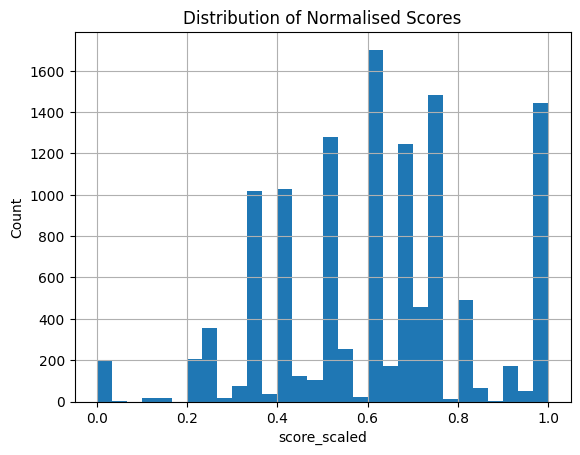

In [9]:
#Saving and Visualize the cleaned dataset
df.to_csv("../data/Processed/asap_cleaned.csv", index=False)
import matplotlib.pyplot as plt
df['score_scaled'].hist(bins=30)
plt.title("Distribution of Normalised Scores")
plt.xlabel("score_scaled")
plt.ylabel("Count")
plt.show()


# ^^ that looks like a lot of full mark scores? am I happy with that? ^^